In [2]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, exponnorm
from util.em import irrelevant_gen

BASE_OUTPUT = './output'
BASE_DATA = './data'

In [3]:
def align_button_interval(button_interval):
    bi_aligned = np.concatenate(((button_interval/2), -(button_interval/2)))
    bi_aligned.sort()
    return bi_aligned

def get_pixel_ioi(data, x, y):
    T = data[:, 0]
    T_c = data[:, 1]
    X = data[:, 2]
    Y = data[:, 3]
    return T_c[(X==x)&(Y==y)] - T[(X==x)&(Y==y)]

### Load Result

In [5]:
# DINO
PID = 1
VERSION = '21080616'
KEY = 'space'
path = f"{BASE_OUTPUT}/S{200+PID}_{'space'}_{VERSION}.hdf5"
f = h5py.File(path, 'r')
dino_w = f['w']
dino_p = f['p']

# TABSONIC
PID = 1
VERSION = '21080616'
KEY = 'all'
path = f"{BASE_OUTPUT}/S{200+PID}_{'O'}_{'all'}_{VERSION}.hdf5"
f = h5py.File(path, 'r')
tabsonic_w = f['w']
tabsonic_p = f['p']

# ET
PID = 1
VERSION = '21080616'
KEY = 'all'
path = f"{BASE_OUTPUT}/S{100+PID}_{32}_{VERSION}.hdf5"
f = h5py.File(path, 'r')
et_w = f['w']
et_p = f['p']

### Load Data

In [6]:
path = f"{BASE_DATA}/S{200+PID}_{'space'}.hdf5"
f = h5py.File(path, 'r')
dino_ioi = h5py.File(path, 'r')['data'][:,:4]
dino_t_input = np.unique(dino_ioi[:,1])
dino_bi = align_button_interval(dino_t_input[1:] - dino_t_input[:-1])
dino_irr = irrelevant_gen(dino_bi)

In [7]:
tabsonic_ioi = None
tabsonic_bi = None
for i, m in enumerate(['B', 'A', 'C', 'D', 'E']):
  path = f"{BASE_DATA}/S{200+PID}_{m}O_all.hdf5"
  _tabsonic_ioi = h5py.File(path, 'r')['data'][:,:4]
  tabsonic_ioi = np.concatenate([tabsonic_ioi, _tabsonic_ioi]) if type(tabsonic_ioi)==np.array else _tabsonic_ioi
  _t_input = np.unique(_tabsonic_ioi[:,1])
  _bi = align_button_interval(_t_input[1:] - _t_input[:-1])
  tabsonic_bi = np.concatenate([tabsonic_bi, _bi]) if type(tabsonic_bi)==np.array else _bi
tabsonic_irr = irrelevant_gen(tabsonic_bi)

In [8]:
path = f"{BASE_DATA}/S{100+PID}_{'32'}.hdf5"
et_ioi = h5py.File(path, 'r')['data'][:]
et_t_input = np.unique(et_ioi[:,1])
et_bi = align_button_interval(et_t_input[1:] - et_t_input[:-1])
et_irr = irrelevant_gen(et_bi)

## Inspecting Result

### Tabsonic

C:\Users\user\anaconda3\envs\prb\lib\site-packages\scipy\stats\_continuous_distns.py:1655: RuntimeWarning: overflow encountered in exp
  return np.exp(self._logpdf(x, K))


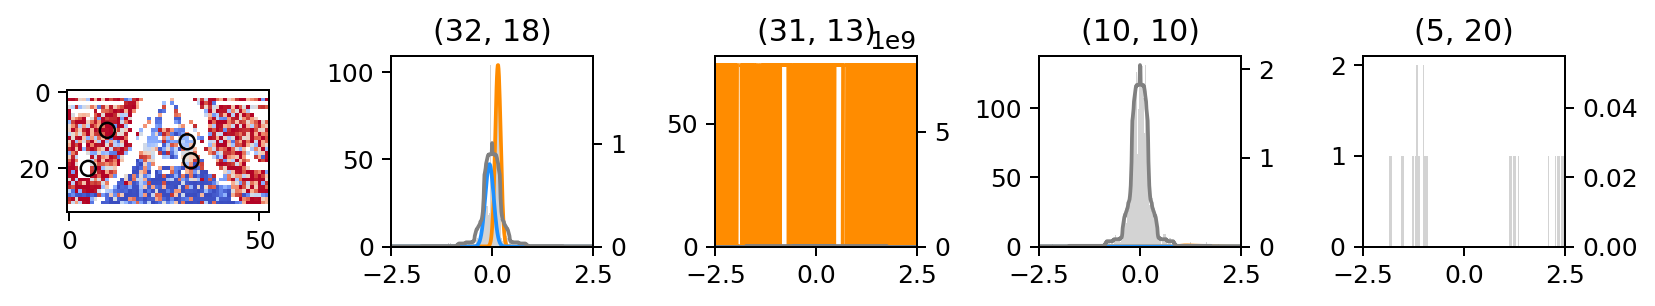

In [9]:
t = np.arange(-5, 5, 0.01)

positions = [(32, 18), (31, 13), (10, 10), (5, 20)]
fig = plt.figure(figsize=(9,1.5), dpi=180)
axs = fig.subplots(1, 5)

ax = axs[0]
react_map = tabsonic_w[:,:,0]/(tabsonic_w[:,:,0]+tabsonic_w[:,:,1])
ax.imshow(react_map, cmap='coolwarm')
ax.scatter([p[0] for p in positions], [p[1] for p in positions], marker='o', facecolors='none', edgecolor='black')


for i, position in enumerate(positions):
    x, y = position
    ax = axs[i+1]
    ax.hist(get_pixel_ioi(tabsonic_ioi, x, y), bins=np.arange(-5, 5, 0.03), color='lightgray')
    w = tabsonic_w[y, x]
    p = tabsonic_p[y, x]
    react = exponnorm.pdf(t, K=p[0], loc=p[1], scale=p[2])* w[0]
    proact = norm.pdf(t, loc=p[3], scale=p[4]) * w[1]
    irrelevance = tabsonic_irr.pdf(t) * w[2]
    ax.set_title(f"({x}, {y})")

    ax_r = ax.twinx()  
    ax_r.plot(t, react, color='darkorange')
    ax_r.plot(t, proact, color='dodgerblue')
    ax_r.plot(t, irrelevance, color='gray')
    ax_r.set_ylim(0)
    ax.set_xlim(-2.5, 2.5)
plt.tight_layout(pad=0.0)
plt.show()


### Dino

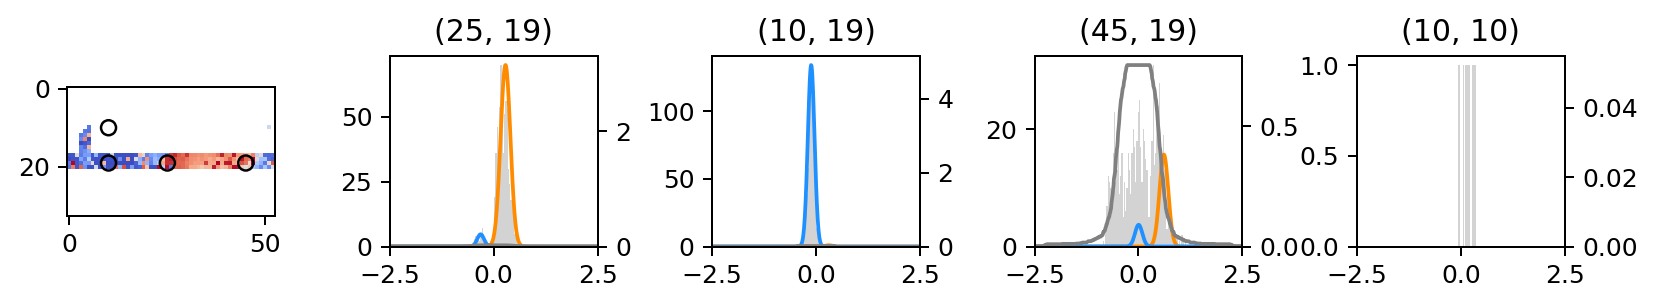

In [11]:
t = np.arange(-5, 5, 0.01)

positions = [(25, 19), (10, 19), (45, 19), (10, 10)]
fig = plt.figure(figsize=(9,1.5), dpi=180)
axs = fig.subplots(1, 5)

ax = axs[0]
react_map = dino_w[:,:,0]/(dino_w[:,:,0]+dino_w[:,:,1])
ax.imshow(react_map, cmap='coolwarm')
ax.scatter([p[0] for p in positions], [p[1] for p in positions], marker='o', facecolors='none', edgecolor='black')


for i, position in enumerate(positions):
    x, y = position
    ax = axs[i+1]
    ax.hist(get_pixel_ioi(dino_ioi, x, y), bins=np.arange(-5, 5, 0.03), color='lightgray')
    w = dino_w[y, x]
    p = dino_p[y, x]
    react = exponnorm.pdf(t, K=p[0], loc=p[1], scale=p[2])* w[0]
    proact = norm.pdf(t, loc=p[3], scale=p[4]) * w[1]
    irrelevance = dino_irr.pdf(t) * w[2]
    ax.set_title(f"({x}, {y})")

    ax_r = ax.twinx()  
    ax_r.plot(t, react, color='darkorange')
    ax_r.plot(t, proact, color='dodgerblue')
    ax_r.plot(t, irrelevance, color='gray')
    ax_r.set_ylim(0)
    ax.set_xlim(-2.5, 2.5)
plt.tight_layout(pad=0.0)
plt.show()


### Expanding Target

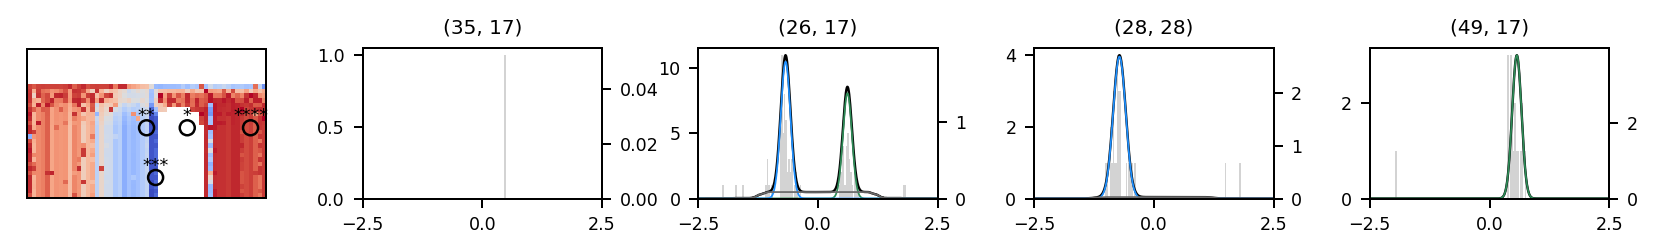

In [12]:
t = np.arange(-5, 5, 0.01)
positions = [(35, 17), (26, 17), (28, 28), (49, 17)]
task_w = et_w
task_p = et_p
task_irr = et_irr
task_ioi = et_ioi
fig = plt.figure(figsize=(9,1.2), dpi=180)
axs = fig.subplots(1, 5)

ax = axs[0]
ax.set_xticks([])
ax.set_yticks([])
react_map = task_w[:,:,0]/(task_w[:,:,0]+task_w[:,:,1])
ax.imshow(react_map, cmap='coolwarm')
ax.scatter([p[0] for p in positions], [p[1] for p in positions], marker='o', facecolors='none', edgecolor='black')
for i, pos in enumerate(positions):
    ax.text(pos[0], pos[1]-1.5, "*"*(i+1), fontsize=7, ha='center')

for i, position in enumerate(positions):
    x, y = position
    ax = axs[i+1]
    ax.hist(get_pixel_ioi(task_ioi, x, y), bins=np.arange(-5, 5, 0.03), color='lightgray')
    w = task_w[y, x]
    p = task_p[y, x]
    react = exponnorm.pdf(t, K=p[0], loc=p[1], scale=p[2])* w[0]
    proact = norm.pdf(t, loc=p[3], scale=p[4]) * w[1]
    irrelevance = task_irr.pdf(t) * w[2]
    sum_pdf = react + proact + irrelevance
    ax.set_title(f"({x}, {y})", fontsize=8)

    ax_r = ax.twinx()  
    ax_r.plot(t, sum_pdf, color='black', linewidth=0.95)
    ax_r.plot(t, react, color='seagreen', linewidth=0.7)
    ax_r.plot(t, proact, color='dodgerblue', linewidth=0.7)
    ax_r.plot(t, irrelevance, color='dimgrey', linewidth=0.7)
    ax_r.set_ylim(0)
    ax.set_xlim(-2.5, 2.5)
    ax.set_xticks([-2.5, 0, 2.5])
    plt.setp(ax_r.get_yticklabels(), fontsize=7)
    plt.setp(ax.get_yticklabels(), fontsize=7)
    plt.setp(ax.get_xticklabels(), fontsize=7)

plt.tight_layout(pad=0.0)
plt.savefig("sample_et.png")
plt.show()